In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from models.fcn import FCN
import pickle
import sde_lib

In [3]:
#log_path ='logs/ksphere/dim_10/n_1/'
#log_name = 've'
dim = 10
n_spheres = 1

log_path =f'logs/ksphere/dim_{dim}/n_{n_spheres}/'
#log_name = 've_sig_0.01_4.0'
#log_name = 've_big_sig_0.01_4.0'
#log_name = 'non_uniform_0.75'
log_name = 'uniform_random'

config_path = log_path + log_name + '/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
config.model.checkpoint_path = log_path  + log_name + "/checkpoints/best/last.ckpt"
#config.model.checkpoint_path = 'logs/ksphere/dim_10/n_2/along_axis_wide/checkpoints/best/epoch=17550--eval_loss_epoch=35.211.ckpt'
config.logging.log_path = log_path
config.logging.log_name = log_name

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def sample(config):
    from sampling.unconditional import get_sampling_fn
    ckpt_path = config.model.checkpoint_path
    pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 1000   
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

In [25]:
samples = sample(config)

100%|██████████| 1000/1000 [08:24<00:00,  1.98it/s]


In [41]:
print(torch.linalg.norm(samples, dim=1).min().item())
print(torch.linalg.norm(samples, dim=1).max().item())
print(torch.linalg.norm(samples, dim=1).mean().item())

0.9295973777770996
1.0206804275512695
0.9991390109062195


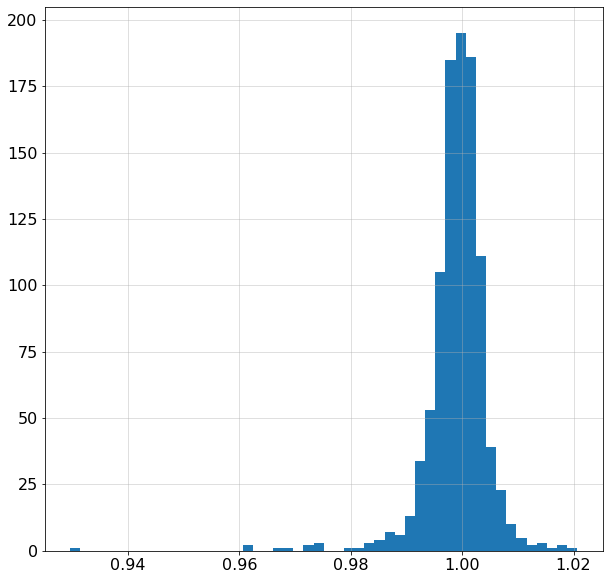

In [87]:
norms=torch.linalg.norm(samples, dim=1).numpy()
plt.figure(figsize=(10,10))
plt.grid(alpha=0.5)
plt.hist(norms, bins=50)
plt.show()

In [53]:
samples_zero = samples.clone()
samples_zero[torch.abs(samples)< 1e-3] =0
print(torch.linalg.norm(samples_zero, dim=1).mean().item())

0.9991320967674255


In [4]:
path = log_path + log_name + '/svd/svd_21000.pkl'
with open(path, 'rb') as f:
    svd = pickle.load(f)

singular_values = svd['singular_values']
normalized_scores = svd['normalized_scores']

In [5]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [6]:
#from scipy.special import softmax as sipysoftmax
dims = []
for sing_vals in singular_values:
    difference = np.array([sing_vals[i-1] - sing_vals[i] for i in range(1, len(sing_vals))])
    probs = softmax(difference)
    d = len(probs) - np.argmax(probs)
    dims.append(d)


In [7]:
np.max(dims)

11

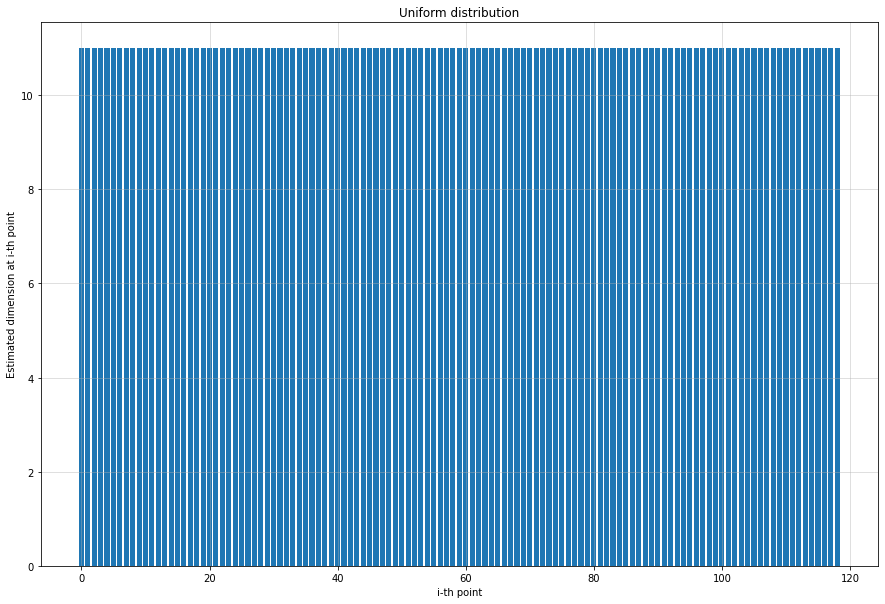

In [15]:
plt.figure(figsize=(15,10))
plt.title('Uniform distribution')
plt.grid(alpha=0.5)
plt.bar(range(len(dims)), np.sort(dims))
plt.xlabel('i-th point')
plt.ylabel('Estimated dimension at i-th point')
plt.savefig('figures/uniform', dpi=300, facecolor='white')
plt.show()

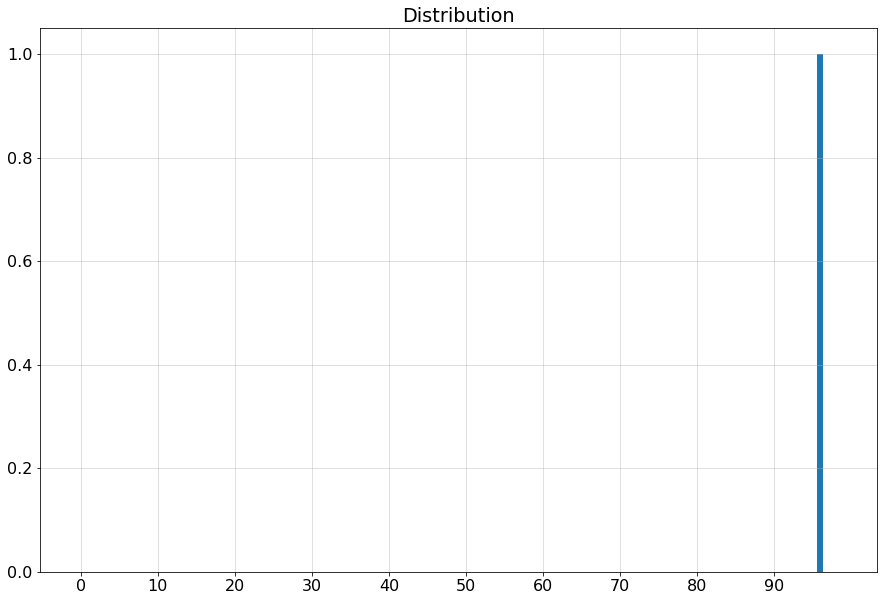

In [177]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,10))
plt.bar(list(range(len(difference))),probs)
plt.grid(alpha=0.5)
plt.title('Distribution')
plt.xticks(np.arange(0, len(difference)+1, 10))
plt.show()

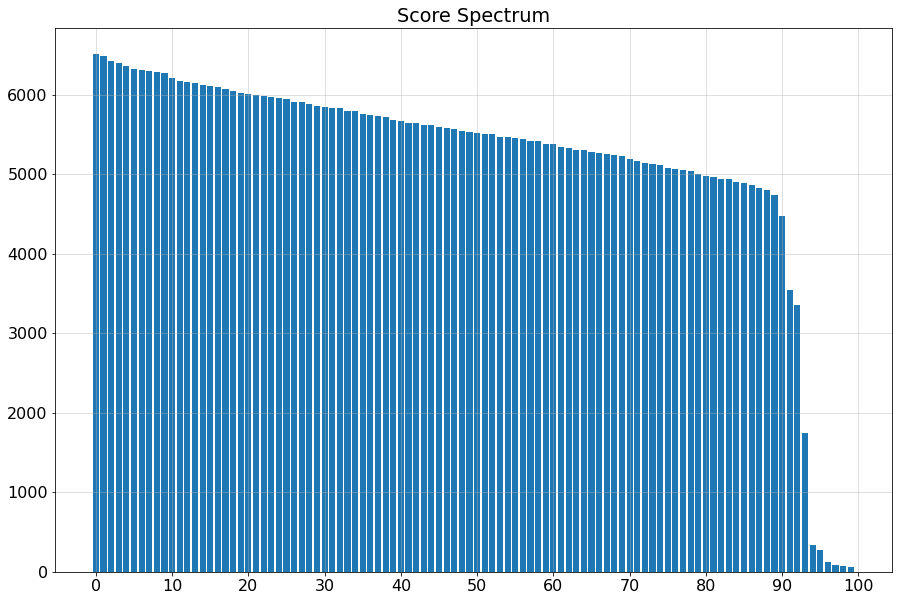

In [153]:
sing_vals = singular_values[50]#(np.array(singular_values)).mean(axis=0)
#difference = [sing_vals[i] - sing_vals[i-1] for i in range(1, len(sing_vals))]
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,10))
plt.bar(list(range(len(sing_vals))),sing_vals)
plt.grid(alpha=0.5)
plt.title('Score Spectrum')
plt.xticks(np.arange(0, len(sing_vals)+1, 10))
plt.show()

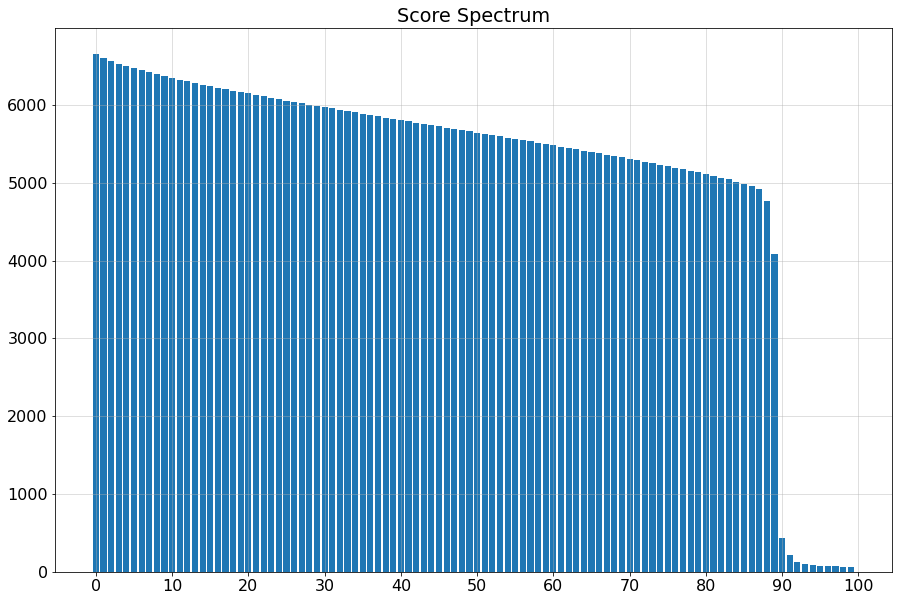

In [14]:
from plot_utils import plot_spectrum
plot_spectrum(singular_values)